# ReadMe 

1. Prerequisites

    - Java 1.8.0_191 (https://www.oracle.com/java/technologies/javase/javase8-archive-downloads.html)

    - Python 3.10.11 (https://www.python.org/downloads/release/python-31011/)

    - Apache Spark 3.0.0 with prebuilt Hadoop 2.7 (https://archive.apache.org/dist/spark/spark-3.0.0/)

    - Visual Studio Code 1.77.3

    - WinUtils.exe for Spark w/ Hadoop version above (https://github.com/cdarlint/winutils)

2. Instructions

    - Guide: https://towardsdatascience.com/installing-apache-pyspark-on-windows-10-f5f0c506bea1

# Implementation details

1. Preprocessing Approach

    - Normalize text to lowercase
    - Removal of punctuation and special characters
    - Removal of stop words
    - Tokenize text into an array

2. Lexicon based sentiment scoring w/ AFINN (https://rdrr.io/cran/textdata/man/lexicon_afinn.html)

    Serves as the "ground truth" approximation of sentiment in a text by utlizing map-reduce to count (word, count) in a tweet, then joins the AFINN dataframe such that each tweet may be labeled -1, 0, 1 for negative, neutral, positive sentiment based on a summing of matched words from AFINN and the corresponding score in [-5, 5].

    A similar process was done for each grouping of religious text.

    The computed categories here are used as the labels when building out ML models with MLlib in Apache Spark via th PySpark library.

3. ML model building (https://spark.apache.org/docs/3.0.0/ml-guide.html)

    - Logistic Regression w/ Count Vector

             Used to predict the probability of a certain event occurring based on the values of the independent variables. 
             
             Count vector uses the frequency of occurrence of each word in a text to count and store it as a vector.

             These word counts are used as the independent variables in the logistic regression model, and the dependent variable is a multivariate label.

    - Logistic Regression w/ TF-IDF

            Similar to the above however, term-frequency (TF) is the freq(word) in the text, and the inverse-document-frequency (IDF) is a measure of how important the word is to the text

    - Naive Bayes

            Probabalistic approach, where the probability of each label class is calculated given a set of features.

            The label class with the highest probability is chosen as the predicted class.

            Relies on Bayes Theorum: P(label | features) = P(features | label) * P(label) / P(features)

            **Assumes label independence

    - Decision Trees

            Partitions data into subsets based on feature values until each subset is of only one label class

            Seperates subsets by entropy or gini index calculations

    - Random Forest

            Extends Decision Tree method, by building decision trees trained on a random subset of the training data and a random subset of the input features.

            This reduces overfitting.

            Predics label class the predictions of all the decision trees in the forest are aggregated, such that a majority vote of the trees in the forest dictacte prediction.

    - OnevsRest

            Divides the multi label class dataset into seveeral binary classification models.

            All relevant trained binary classifying models are applied and the model with the highest probability score is used as the predictted class label.

4. ML model evaluation

    - All models calculate accuracy rate

    - Example on LR model of....

    Accuracy: Overall correctness of a classification model's predictions

    FalsePositiveRate: Opposite of Recall

    F_Measure: A metric that combines precision and recall into a single measure of a classification model's performance

    Precision: A metric that measures the ability of a classification model to make correct positive predictions

    Recall: Ability of a classification model to identify all relevant instances of a particular class in a dataset

# Limitations of Approach

    - System Resource Limitations

        CPU: Ryzen 5 w/ 6 cores
        RAM: 32 GB
        DISK: ~250GB available

        Data Spillage: When processing a large dataset with limited memory, Spark may start swapping data to disk, which can significantly slow down processing times.

        Read/Write Bandwidth: When running Spark on a distributed cluster, data is spread across multiple machines. Since I am running Spark locally, all data must be transferred to and from my system, which relies on memory write times to RAM or Disk.

        Processing Power: My loccal instance of Apache Spark is bound by my processor and the available amount of cores.

    - Scalability Issues 

        Single Executor: Negates the benifit of optimized parrellelism since job stages will be run suquentially.

        Fault Tolerance: Greater risk  of job build failure due to hardware or software dependencies. Once a job fails it cannot be repaired it mustt be instantiated from the beginning.

# Libraries

In [3]:
import findspark
findspark.init()

In [4]:
import re
import string
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.types as T
import pyspark.sql.functions as F
from IPython.display import display_html 
from operator import add
import py4j
import pyspark  
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark import SparkContext
import pyspark.sql.types as T
import pyspark.sql.functions as F
from IPython.display import display_html
from itertools import chain,cycle
from pyspark.sql import SparkSession
from wordcloud import (WordCloud, get_single_color_func)
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, RegexTokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.sql.window import Window
from pyspark.storagelevel import StorageLevel

# Spark Contexts

In [5]:
spark = SparkSession.builder \
       .master("local[*]") \
       .appName("CS724 Semester Project") \
       .config("spark.driver.memory", "10g") \
       .config("spark.executor.memory", "2g") \
       .getOrCreate()

sc = spark.sparkContext.getOrCreate()

sqlContext = SQLContext(sc)

spark.sparkContext._conf.getAll() 

[('spark.executor.memory', '2g'),
 ('spark.driver.host', 'DESKTOP-U8NS6GD'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1682964213326'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.memory', '10g'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.driver.port', '40377'),
 ('spark.app.name', 'CS724 Semester Project'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [6]:
sc.uiWebUrl

'http://DESKTOP-U8NS6GD:4040'

# I/O

In [7]:
pathBuddhism = "/Users/dusti/Documents/Scripts/CS724_Project/input/buddhism/"
pathBibleKJV = "/Users/dusti/Documents/Scripts/CS724_Project/input/christianity/bible_kjv.txt"
pathHinduism = "/Users/dusti/Documents/Scripts/CS724_Project/input/hinduism/"
pathKoran = "/Users/dusti/Documents/Scripts/CS724_Project/input/islam/koran.txt"
pathJudaism = "/Users/dusti/Documents/Scripts/CS724_Project/input/judaism/tanakh.txt"

In [8]:
stop_words = sc.textFile("/Users/dusti/Documents/Scripts/CS724_Project/input/stop_words.txt").collect()
positive_words = sc.textFile("/Users/dusti/Documents/Scripts/CS724_Project/input/positive_words.txt").collect()
negative_words = sc.textFile("/Users/dusti/Documents/Scripts/CS724_Project/input/negative_words.txt").collect()

# Word Counts

1. Map-Reduce text files for (word, count)

2. .split() to tokenize

3. Remove punctuation with a Regex pattern

4. Remove stop words from tokens

5. Create a lexicon Spark Dataframe from AFINN

6. Use Spark SQL to join AFINN_DF to [religion_group]_DF such tthat the schema is (word, score, count, type)

In [9]:
def CountWords(path: str, type: str):

    lines = sc.textFile(path)

    words = lines.flatMap(lambda line: line.split()).map(lambda word: word.lower())
    words = words.map(lambda word: re.sub(r'[^\w\s]', '', word))

    if type == 'stop':
        words = words.filter(lambda word: word not in stop_words)

    if type == 'positive':
        words = words.filter(lambda word: word in positive_words)

    if type == 'negative':
        words = words.filter(lambda word: word in negative_words)

    counts = words.map(lambda word: (word, 1)).reduceByKey(add).sortBy(lambda x: x[1], ascending=False)

    return counts

In [10]:
afinnDF = sc.textFile("/Users/dusti/Documents/Scripts/CS724_Project/input/afinn.txt").map(lambda line: line.split("\t")).toDF(['word','score'])
afinnDF = afinnDF.withColumn('score', F.col('score').cast('integer'))
afinnDF.show(5)

+---------+-----+
|     word|score|
+---------+-----+
|  abandon|   -2|
|abandoned|   -2|
| abandons|   -2|
| abducted|   -2|
|abduction|   -2|
+---------+-----+
only showing top 5 rows



In [11]:
countsBuddhism = CountWords(pathBuddhism, 'stop').toDF(['word','count'])

In [12]:
buddhismDF = afinnDF.join(countsBuddhism, afinnDF.word == countsBuddhism.word).select(afinnDF.word, afinnDF.score, "count")

buddhismDF.withColumn("type", \
           F.when((buddhismDF.score > 0), "positive") \
           .when((buddhismDF.score < 0), "negative") \
           .otherwise("neutral")
).sort(F.desc("count")).show(5)

+-------+-----+-----+--------+
|   word|score|count|    type|
+-------+-----+-----+--------+
| matter|    1| 4321|positive|
|feeling|    1| 3941|positive|
|  death|   -2| 3557|negative|
|  wrong|   -2| 3436|negative|
| hatred|   -3| 2985|negative|
+-------+-----+-----+--------+
only showing top 5 rows



In [13]:
countsBibleKJV = CountWords(pathBibleKJV, 'stop').toDF(['word','count'])

In [14]:
bibleKJVDF = afinnDF.join(countsBibleKJV, afinnDF.word == countsBibleKJV.word).select(afinnDF.word, afinnDF.score, "count")

bibleKJVDF.withColumn("type", \
           F.when((bibleKJVDF.score > 0), "positive") \
           .when((bibleKJVDF.score < 0), "negative") \
           .otherwise("neutral")
).sort(F.desc("count")).show(5)

+------+-----+-----+--------+
|  word|score|count|    type|
+------+-----+-----+--------+
|   god|    1| 4442|positive|
| jesus|    1|  983|positive|
|  evil|   -3|  613|negative|
|heaven|    2|  582|positive|
|spirit|    1|  505|positive|
+------+-----+-----+--------+
only showing top 5 rows



In [15]:
countsKoran = CountWords(pathKoran, 'stop').toDF(['word','count'])

In [16]:
koranDF = afinnDF.join(countsKoran, afinnDF.word == countsKoran.word).select(afinnDF.word, afinnDF.score, "count")

koranDF.withColumn("type", \
           F.when((koranDF.score > 0), "positive") \
           .when((koranDF.score < 0), "negative") \
           .otherwise("neutral")
).sort(F.desc("count")).show(5)

+------+-----+-----+--------+
|  word|score|count|    type|
+------+-----+-----+--------+
|   god|    1| 3180|positive|
|  fear|   -2|  310|negative|
| mercy|    2|  194|positive|
|  evil|   -3|  184|negative|
|heaven|    2|  134|positive|
+------+-----+-----+--------+
only showing top 5 rows



In [17]:
countsJudaism = CountWords(pathJudaism, 'stop').toDF(['word','count'])

In [18]:
judaismDF = afinnDF.join(countsJudaism, afinnDF.word == countsJudaism.word).select(afinnDF.word, afinnDF.score, "count")

judaismDF.withColumn("type", \
           F.when((judaismDF.score > 0), "positive") \
           .when((judaismDF.score < 0), "negative") \
           .otherwise("neutral")
).sort(F.desc("count")).show(5)

+------+-----+-----+--------+
|  word|score|count|    type|
+------+-----+-----+--------+
|   god|    1| 3056|positive|
|  evil|   -3|  520|negative|
|  gold|    2|  384|positive|
|heaven|    2|  330|positive|
|wicked|   -2|  297|negative|
+------+-----+-----+--------+
only showing top 5 rows



In [19]:
countsHinduism = CountWords(pathHinduism, 'stop').toDF(['word','count'])

In [20]:
hinduismDF = afinnDF.join(countsHinduism, afinnDF.word == countsHinduism.word).select(afinnDF.word, afinnDF.score, "count")

hinduismDF.withColumn("type", \
           F.when((hinduismDF.score > 0), "positive") \
           .when((hinduismDF.score < 0), "negative") \
           .otherwise("neutral")
).sort(F.desc("count")).show(5)

+--------+-----+-----+--------+
|    word|score|count|    type|
+--------+-----+-----+--------+
|  heaven|    2| 2055|positive|
|strength|    2| 1855|positive|
|     god|    1| 1598|positive|
|  wealth|    3| 1557|positive|
|  strong|    2| 1255|positive|
+--------+-----+-----+--------+
only showing top 5 rows



# Word Clouds

In [21]:
def createWordCloud(text):
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

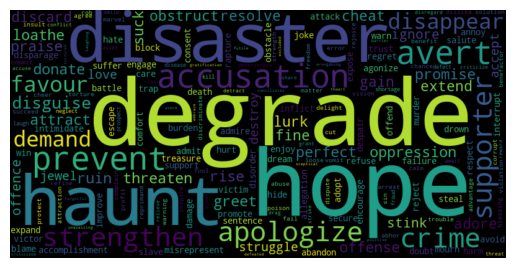

In [22]:
buddhismPDF = buddhismDF.toPandas()
textBuddhism = " ".join(word for word in buddhismPDF.word.astype(str))
createWordCloud(textBuddhism)

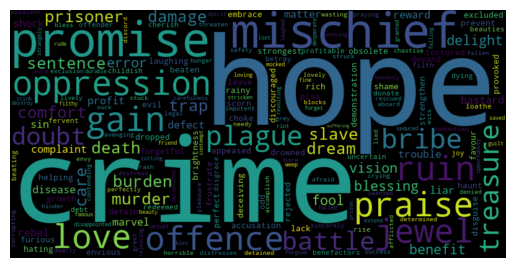

In [23]:
bibleKJVPDF = bibleKJVDF.toPandas()
textBibleKJV = " ".join(word for word in bibleKJVPDF.word.astype(str))
createWordCloud(textBibleKJV)

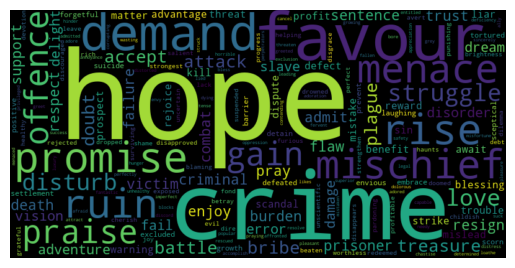

In [24]:
koranPDF = koranDF.toPandas()
textKoran = " ".join(word for word in koranPDF.word.astype(str))
createWordCloud(textKoran)

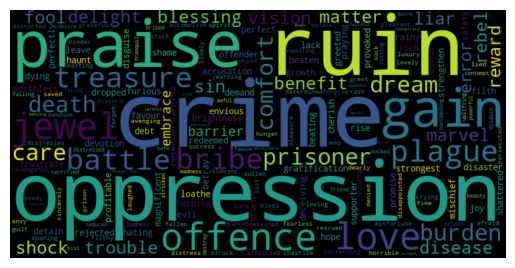

In [25]:
judaismPDF = judaismDF.toPandas()
textJudaism = " ".join(word for word in judaismPDF.word.astype(str))
createWordCloud(textJudaism)

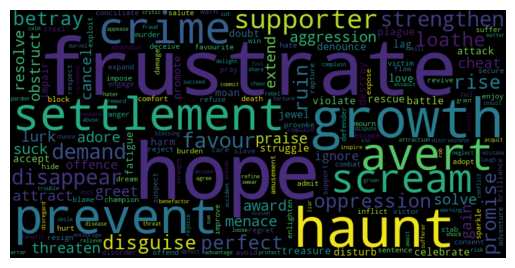

In [26]:
hinduismPDF = hinduismDF.toPandas()
textHinduism = " ".join(word for word in hinduismPDF.word.astype(str))
createWordCloud(textHinduism)

In [27]:
print(type(buddhismDF))
print(type(bibleKJVDF))
print(type(hinduismDF))
print(type(judaismDF))
print(type(koranDF))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


# Data Preprocessing

In [28]:
tweetsSchema = T.StructType([
    T.StructField("user_name", T.StringType()),
    T.StructField("user_location", T.StringType()),
    T.StructField("user_description", T.StringType()),
    T.StructField("user_created", T.StringType()),
    T.StructField("user_followers", T.IntegerType()),
    T.StructField("user_friends", T.IntegerType()),
    T.StructField("user_favourites", T.IntegerType()),
    T.StructField("user_verified", T.StringType()),
    T.StructField("date", T.DateType()),
    T.StructField("text", T.StringType()),
    T.StructField("hashtags", T.StringType()),
    T.StructField("source", T.StringType()),
    T.StructField("is_retweet", T.StringType())
])

tweetsRawDF = sqlContext.read.format("csv").option("header", "true").schema(tweetsSchema).load("/Users/dusti/Documents/Scripts/CS724_Project/input/tweets/covid19_tweets.csv")
#tweetsRawDF.show(5)

In [29]:
tweetsDF = tweetsRawDF.select("text").dropna()
#tweetsDF.show(5)

In [30]:
cleanTweetsDF = tweetsDF.withColumn('clean_text', F.regexp_replace('text', '[^\w\s]+', ''))
cleanTweetsDF = cleanTweetsDF.withColumn('clean_text', F.lower(cleanTweetsDF['clean_text']))
cleanTweetsDF = cleanTweetsDF.withColumn('words', F.split(cleanTweetsDF['clean_text'], ' '))
cleanTweetsDF = cleanTweetsDF.withColumn("index", F.monotonically_increasing_id())
#cleanTweetsDF.show(5)

In [31]:
df_exploded = cleanTweetsDF.select("index", F.explode(F.col("words")).alias("word"))
df_scored = df_exploded.join(afinnDF, "word")
df_grouped = df_scored.groupBy(df_scored.index).agg(F.collect_list("score").alias("afinn_scores"))

In [32]:
cleanTweetsDF = cleanTweetsDF.join(df_grouped, 'index', 'outer')

In [33]:
cleanTweetsDF = cleanTweetsDF.withColumn('token_count', F.size('words').cast("string"))

In [34]:
def sum_array(arr):
    if arr is None:
        return 0  # Return 0 for NoneType values
    else:
        return sum(arr)

sum_array_udf = udf(sum_array, T.StringType())

cleanTweetsDF = cleanTweetsDF.withColumn("sentiment", sum_array_udf("afinn_scores").cast("int"))

In [35]:
cleanTweetsDF = cleanTweetsDF.withColumn("category", F.when(cleanTweetsDF.sentiment < 0, -1).when(cleanTweetsDF.sentiment > 0, 1).otherwise(0))

In [ ]:
#cleanTweetsDF.sort(F.asc('index')).show(5)

# Model One: Predicting Overall Sentiment (Positive, Negative, Neutral)

In [36]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

countVectors = CountVectorizer(inputCol="words", outputCol="features", vocabSize=30000, minDF=5)
label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")

pipeline = Pipeline(stages=[countVectors, label_stringIdx])

pipelineFit = pipeline.fit(cleanTweetsDF)
dataset = pipelineFit.transform(cleanTweetsDF)
#dataset.show(5)

In [37]:
# set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
#print("Training Dataset Count: " + str(trainingData.count()))
#print("Test Dataset Count: " + str(testData.count()))

In [38]:
trainingData

DataFrame[index: bigint, text: string, clean_text: string, words: array<string>, afinn_scores: array<int>, token_count: string, sentiment: int, category: int, features: vector, label: double]

In [39]:
testData

DataFrame[index: bigint, text: string, clean_text: string, words: array<string>, afinn_scores: array<int>, token_count: string, sentiment: int, category: int, features: vector, label: double]

In [40]:
trainingData.persist()
testData.persist()

DataFrame[index: bigint, text: string, clean_text: string, words: array<string>, afinn_scores: array<int>, token_count: string, sentiment: int, category: int, features: vector, label: double]

## Logistic Regression using Count Vector

A "bag of words" is being generated to represent the given tweet text data, such that the ordinal nature of the text is ignored and only the count of occurences is used to create a vector of word frequencies by row in the Spark Dataframe where each array index corresponds of the generated array corresponds to a word in this "bag of words" and the corresponding value at this index is the frequency value.

In [41]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0).select("clean_text","category","probability","label","prediction")\
.orderBy("probability", ascending=False)

#predictions.show(10)

DataFrame[clean_text: string, category: int, probability: vector, label: double, prediction: double]

In [42]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
lr_CV_Accuracy = evaluator.evaluate(predictions)
print(lr_CV_Accuracy)

0.8162074838189236


In [43]:
trainingSummary = lrModel.summary

# for multiclass, we can inspect metrics on a per-label basis
print("\nFalse positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nPrecision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("\nRecall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("\nF-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("\nAccuracy: %s\n\nFPR: %s\n\nTPR: %s\n\nF-measure: %s\n\nPrecision: %s\n\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))


False positive rate by label:
label 0: 0.14468208651891998
label 1: 0.017143792684067734
label 2: 0.016897726742286328

True positive rate by label:
label 0: 0.9564309653315752
label 1: 0.8422914857345042
label 2: 0.85111132679802

Precision by label:
label 0: 0.8534170016668301
label 1: 0.9469839432952408
label 2: 0.9478292199603675

Recall by label:
label 0: 0.9564309653315752
label 1: 0.8422914857345042
label 2: 0.85111132679802

F-measure by label:
label 0: 0.9019922795927356
label 1: 0.8915748795560171
label 2: 0.8968703122869223

Accuracy: 0.8980797763312494

FPR: 0.07680338227652334

TPR: 0.8980797763312494

F-measure: 0.8978569682558095

Precision: 0.9033916151222945

Recall: 0.8980797763312494


## Logistic Regression using TF-IDF

Term frequency-inverse document frequency creates a weighted "bag of words" of the input tweet text, but is more robust than the previous count vector feature method in that it takes into account the frequency of a word in a document of text as well as the inverse frequency of a word in all documents in the corpus.

In [44]:
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=30000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

pipeline = Pipeline(stages=[hashingTF, idf, label_stringIdx])

pipelineFit = pipeline.fit(cleanTweetsDF)
dataset = pipelineFit.transform(cleanTweetsDF)

(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False)

DataFrame[clean_text: string, category: int, probability: vector, label: double, prediction: double]

In [45]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
lr_TFIDF_Accuracy = evaluator.evaluate(predictions)
print(lr_TFIDF_Accuracy)

0.7577791633330189


In [46]:
trainingSummary = lrModel.summary

# for multiclass, we can inspect metrics on a per-label basis
print("\nFalse positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nPrecision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("\nRecall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("\nF-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("\nAccuracy: %s\n\nFPR: %s\n\nTPR: %s\n\nF-measure: %s\n\nPrecision: %s\n\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))


False positive rate by label:
label 0: 0.15952127487983483
label 1: 0.022113855365328842
label 2: 0.022674228632777856

True positive rate by label:
label 0: 0.9499111770415545
label 1: 0.818231528836566
label 2: 0.8272994920573296

Precision by label:
label 0: 0.839858803717737
label 1: 0.9308061034066376
label 2: 0.9293814058297594

Recall by label:
label 0: 0.9499111770415545
label 1: 0.818231528836566
label 2: 0.8272994920573296

F-measure by label:
label 0: 0.8915014480796831
label 1: 0.8708959567256668
label 2: 0.8753744244561217

Accuracy: 0.882299465699265

FPR: 0.08660882457720655

TPR: 0.882299465699265

F-measure: 0.8817324555848873

Precision: 0.8878387928148179

Recall: 0.882299465699265


## Naive Bayes

Probabilistic classification algorithm that is based on Bayes Theorem, by first estimating the probabilities of each class based on the input features. These probabilities are estimated by the probability of hypothesis (in this case, the category/label) based on the prior knowledge (the prior probability of the category/label) and the observed evidence (the input features). The assumption in Naive Bayes is that all features are independent of each other given the class. This means that the probability of a particular feature occurring does not depend on the occurrence of any other feature in the input data. This assumption simplifies the calculation of the probability of each class given the input features.

Naive Bayes calculates the probability of each class given the input features using Bayes' theorem. The class with the highest probability is then assigned to the input data point.

In [35]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1)
nbModel = nb.fit(trainingData)
predictions = nbModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False)

DataFrame[clean_text: string, category: int, probability: vector, label: double, prediction: double]

In [36]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
nbAccuracy = evaluator.evaluate(predictions)
print(nbAccuracy)

0.6790508985866582


## Decision Tree Classification


Predicts the class label of an input data point by recursively partitioning the feature space into subsets that are associated with different class labels.

A decision tree consists of internal nodes, branches, and leaf nodes. The internal nodes represent a test on a feature, and the branches represent the possible outcomes of the test. The leaf nodes represent the final decision, which is the class label assigned to the input data point.

The algorithm begins by selecting the most important feature that can best partition the input data into subsets with different class labels. The feature is selected using a measure of impurity, such as the Gini impurity or the entropy. The measure of impurity evaluates how well a feature splits the input data into subsets that have different class labels.

The input data is partitioned into subsets based on the values of the selected feature. The partitioning process is repeated recursively for each subset until a stopping criterion is met. The stopping criterion could be a predefined depth of the tree, a minimum number of data points in a leaf node, or a minimum reduction in impurity.

In [37]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(trainingData)
predictions = dtModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False)

DataFrame[clean_text: string, category: int, probability: vector, label: double, prediction: double]

In [38]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
dtAccuracy = evaluator.evaluate(predictions)
print(dtAccuracy) 

0.38105544664522306


## Random Forest Model


A forest of decision trees, where each tree is trained on a random subset of the input features and a random subset of the training data. The random selection of features and training data helps to reduce overfitting and improve the generalization performance of the model.

Each decision tree is built using a subset of the input features and a subset of the training data. The splitting criterion for each node is based on the Gini impurity or the information gain, which measures the quality of the split in terms of how well it separates the input data into different classes.

The random forest takes the average prediction of all decision trees in the forest. Each tree makes a prediction based on the features of the input data point and the decision rules learned during the training phase. The average prediction of all trees gives a final prediction that is less sensitive to the specific training data and more robust to noise and outliers.

In [39]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(trainingData)
rfPredictions = rfModel.transform(testData)
rfPredictions.filter(rfPredictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False)

DataFrame[clean_text: string, category: int, probability: vector, label: double, prediction: double]

In [40]:
rfEvaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
rfAccuracy = rfEvaluator.evaluate(rfPredictions)
print(rfAccuracy) 

0.3030500533159491


## OnevsRest Classification Model


A binary classifier for each class label, where the positive class is the target class and the negative class is all the other classes combined. During the prediction phase, the input data point is passed through all the binary classifiers, and the class label with the highest confidence score is selected as the predicted class label.

In [41]:
from pyspark.ml.classification import LogisticRegression, OneVsRest

ovrLR = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

ovr = OneVsRest(classifier=ovrLR)

ovrModel = ovr.fit(trainingData)

# score the model on test data.
ovrPredictions = ovrModel.transform(testData)

ovrPredictions.filter(ovrPredictions['prediction'] == 0) \
    .select("clean_text","category","label","prediction")

DataFrame[clean_text: string, category: int, label: double, prediction: double]

In [42]:
ovrEvaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
ovrAccuracy = ovrEvaluator.evaluate(ovrPredictions)
print(ovrAccuracy)

0.7389304474385188


## Model One Visualization

In [43]:
model = ['LR CV', 'LR TF-IDF', 'Naive Bayes', 'Random Forest', 'OneVsRest']
accuracy = [lr_CV_Accuracy, lr_TFIDF_Accuracy, nbAccuracy, rfAccuracy, ovrAccuracy]

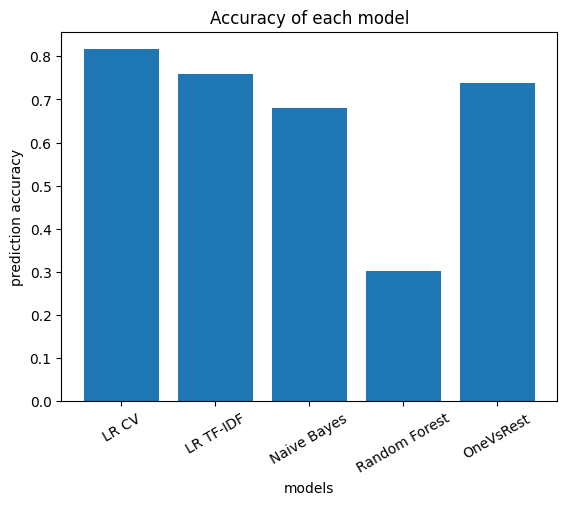

In [44]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(model))
    plt.bar(index, accuracy)
    plt.xlabel('models', fontsize=10)
    plt.ylabel('prediction accuracy', fontsize=10)
    plt.xticks(index, model, fontsize=10, rotation=30)
    plt.title('Accuracy of each model')
    plt.show()
    
plot_bar_x()

In [ ]:
spark.catalog.clearCache()

# Data Preprocessing

In [60]:
tweetsDF2 = tweetsRawDF.select("text").dropna()

cleanTweetsDF2 = tweetsDF2.withColumn('clean_text', F.regexp_replace('text', '[^\w\s]+', ''))
cleanTweetsDF2 = cleanTweetsDF2.withColumn('clean_text', F.lower(cleanTweetsDF2['clean_text']))
cleanTweetsDF2 = cleanTweetsDF2.withColumn('words', F.split(cleanTweetsDF2['clean_text'], ' '))
cleanTweetsDF2 = cleanTweetsDF2.withColumn("index", F.monotonically_increasing_id())

df_exploded_christinaity = cleanTweetsDF2.select("index", F.explode(F.col("words")).alias("word"))
df_scored_christinaity = df_exploded_christinaity.join(bibleKJVDF, "word")
df_grouped_christinaity = df_scored_christinaity.groupBy(df_scored_christinaity.index).agg(F.collect_list("score").alias("afinn_scores_christianity"))

cleanTweetsDF2 = cleanTweetsDF2.join(df_grouped_christinaity, 'index', 'outer')

cleanTweetsDF2 = cleanTweetsDF2.withColumn("sentiment_christianity", sum_array_udf("afinn_scores_christianity").cast("int"))
#cleanTweetsDF2.sort(F.asc('index')).show(5)

In [61]:
df_exploded_islam = cleanTweetsDF2.select("index", F.explode(F.col("words")).alias("word"))
df_scored_islam = df_exploded_islam.join(koranDF, "word")
df_grouped_islam = df_scored_islam.groupBy(df_scored_islam.index).agg(F.collect_list("score").alias("afinn_scores_islam"))

cleanTweetsDF2 = cleanTweetsDF2.join(df_grouped_islam, 'index', 'outer')
cleanTweetsDF2 = cleanTweetsDF2.withColumn("sentiment_islam", sum_array_udf("afinn_scores_islam").cast("int"))

In [62]:
df_exploded_judaism = cleanTweetsDF2.select("index", F.explode(F.col("words")).alias("word"))
df_scored_judaism = df_exploded_judaism.join(judaismDF, "word")
df_grouped_judaism = df_scored_judaism.groupBy(df_scored_judaism.index).agg(F.collect_list("score").alias("afinn_scores_judaism"))

cleanTweetsDF2 = cleanTweetsDF2.join(df_grouped_judaism, 'index', 'outer')
cleanTweetsDF2 = cleanTweetsDF2.withColumn("sentiment_judaism", sum_array_udf("afinn_scores_judaism").cast("int"))

In [63]:
df_exploded_buddhism = cleanTweetsDF2.select("index", F.explode(F.col("words")).alias("word"))
df_scored_buddhism = df_exploded_buddhism.join(buddhismDF, "word")
df_grouped_buddhism = df_scored_buddhism.groupBy(df_scored_buddhism.index).agg(F.collect_list("score").alias("afinn_scores_buddhism"))

cleanTweetsDF2 = cleanTweetsDF2.join(df_grouped_buddhism, 'index', 'outer')
cleanTweetsDF2 = cleanTweetsDF2.withColumn("sentiment_buddhism", sum_array_udf("afinn_scores_buddhism").cast("int"))

In [64]:
df_exploded_hinduism = cleanTweetsDF2.select("index", F.explode(F.col("words")).alias("word"))
df_scored_hinduism = df_exploded_hinduism.join(hinduismDF, "word")
df_grouped_hinduism = df_scored_hinduism.groupBy(df_scored_hinduism.index).agg(F.collect_list("score").alias("afinn_scores_hinduism"))

cleanTweetsDF2 = cleanTweetsDF2.join(df_grouped_hinduism, 'index', 'outer')
cleanTweetsDF2 = cleanTweetsDF2.withColumn("sentiment_hinduism", sum_array_udf("afinn_scores_hinduism").cast("int"))

In [65]:
def religion_category(christianity, islam, judaism, buddhism, hinduism):

  if abs(christianity) > max(abs(islam),abs(judaism),abs(buddhism),abs(hinduism)):
    return 1
  if abs(islam) > max(abs(christianity),abs(judaism),abs(buddhism),abs(hinduism)):
    return 2
  if abs(judaism) > max(abs(christianity),abs(islam),abs(buddhism),abs(hinduism)):
    return 3
  if abs(buddhism) > max(abs(christianity),abs(islam),abs(judaism),abs(hinduism)):
    return 4
  if abs(hinduism) > max(abs(christianity),abs(islam),abs(judaism),abs(buddhism)):
    return 5
  else:
    return 0

rel_cat = F.udf(religion_category, T.IntegerType())

In [66]:
cleanTweetsDF2 = cleanTweetsDF2.withColumn('category', rel_cat('sentiment_christianity','sentiment_islam','sentiment_judaism','sentiment_buddhism','sentiment_hinduism'))

In [67]:
cleanTweetsDF2.dtypes

[('index', 'bigint'),
 ('text', 'string'),
 ('clean_text', 'string'),
 ('words', 'array<string>'),
 ('afinn_scores_christianity', 'array<int>'),
 ('sentiment_christianity', 'int'),
 ('afinn_scores_islam', 'array<int>'),
 ('sentiment_islam', 'int'),
 ('afinn_scores_judaism', 'array<int>'),
 ('sentiment_judaism', 'int'),
 ('afinn_scores_buddhism', 'array<int>'),
 ('sentiment_buddhism', 'int'),
 ('afinn_scores_hinduism', 'array<int>'),
 ('sentiment_hinduism', 'int'),
 ('category', 'int')]

In [97]:
cleanTweetsDF2 = cleanTweetsDF2.select('clean_text','words','category').persist()

# Model Two: Predicting Religious Overlap

In [74]:
pipelineFit2 = pipeline.fit(cleanTweetsDF2)
dataset2 = pipelineFit2.transform(cleanTweetsDF2)
#dataset2.show(5)

In [75]:
(trainingData2, testData2) = dataset2.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset2 Count: " + str(trainingData2.count()))
print("Test Dataset2 Count: " + str(testData2.count()))

Training Dataset2 Count: 116601
Test Dataset2 Count: 49944


In [71]:
trainingData2

DataFrame[words: array<string>, category: int, rawFeatures: vector, features: vector, label: double]

In [72]:
testData2

DataFrame[words: array<string>, category: int, rawFeatures: vector, features: vector, label: double]

In [101]:
trainingData2.cache()

DataFrame[clean_text: string, words: array<string>, category: int, rawFeatures: vector, features: vector, label: double]

In [100]:
testData2.cache()

DataFrame[clean_text: string, words: array<string>, category: int, rawFeatures: vector, features: vector, label: double]

## Logistic Regression using Count Vector

In [76]:
lr2 = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel2 = lr2.fit(trainingData)

predictions2 = lrModel2.transform(testData2)

predictions2.filter(predictions2['prediction'] == 0).select("clean_text","category","probability","label","prediction")\
.orderBy("probability", ascending=False).show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|flugreisen in der coronakri...|       0|[0.9815692098740764,0.01109...|  0.0|       0.0|
|houbizjournal do in person ...|       0|[0.9806217054829403,0.01225...|  0.0|       0.0|
|davidharsanyi do in person ...|       0|[0.976329058089783,0.016040...|  0.0|       0.0|
|covid19 vaccine covishield ...|       0|[0.975454057021414,0.014255...|  0.0|       0.0|
|jammuandkashmir constructio...|       0|[0.9749088304383304,0.00662...|  0.0|       0.0|
|murielvieux do in person ea...|       0|[0.9714742552801381,0.01218...|  0.0|       0.0|
|realmattcouch do in person ...|       0|[0.9697733746606325,0.01101...|  0.0|       0.0|
|gzzyzyx markp1950 ukrainetr...|       0|[0.9696758506367542,0.01081...|  0.0|       0.0|
|bsloopjoh

In [77]:
lr_CV_Accuracy2 = evaluator.evaluate(predictions2)
print(lr_CV_Accuracy2)

0.6768067158118938


## Logistic Regression using TF-IDF

In [78]:
lr3 = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel3 = lr3.fit(trainingData2)

predictions3 = lrModel3.transform(testData2)

predictions3.filter(predictions3['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .cache()

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|this bilobed hemangiopericy...|       0|[0.9946075081623563,0.00226...|  0.0|       0.0|
|1521 the usa reported 58407...|       0|[0.9939686770528416,0.00246...|  0.0|       0.0|
|dnc ind 509k usa 485k bra 1...|       0|[0.9930815271532797,0.00274...|  0.0|       0.0|
|hmm exam se nahi dar rahe h...|       0|[0.9922422781515446,0.00391...|  0.0|       0.0|
|rlfreedm inc_yv jcorippo mr...|       0|[0.9919485050090903,0.00394...|  0.0|       0.0|
|places are available today ...|       0|[0.9913328531977125,0.00384...|  0.0|       0.0|
|debrennie2 leahr77 vfl2013 ...|       0|[0.9907963425516867,0.00440...|  0.0|       0.0|
|byo power cables table chai...|       0|[0.990675157180262,0.004150...|  0.0|       0.0|
|shaunratc

In [102]:
lr_TFIDF_Accuracy2 = evaluator.evaluate(predictions3)
print(lr_TFIDF_Accuracy2)

0.9173928751908059


In [ ]:
predictions3.unpersist()

## Naive Bayes 

In [103]:
nbModel2 = nb.fit(trainingData2)
predictions4 = nbModel2.transform(testData2)
predictions4.filter(predictions4['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .cache()

DataFrame[clean_text: string, category: int, probability: vector, label: double, prediction: double]

In [104]:
nbAccuracy2 = evaluator.evaluate(predictions4)
print(nbAccuracy2)

0.8459593972937063


In [105]:
predictions4.unpersist()

DataFrame[clean_text: string, words: array<string>, category: int, rawFeatures: vector, features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double]

## Decision Tree Classification

In [106]:
dtModel2 = dt.fit(trainingData2)
predictions5 = dtModel2.transform(testData2)
predictions5.filter(predictions5['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .cache()

DataFrame[clean_text: string, category: int, probability: vector, label: double, prediction: double]

In [107]:
dtAccuracy2 = evaluator.evaluate(predictions2)
print(dtAccuracy2) 

0.6768067158118938


In [108]:
predictions5.unpersist()

DataFrame[clean_text: string, words: array<string>, category: int, rawFeatures: vector, features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double]

## Random Forest Classification

In [118]:
rfModel2 = rf.fit(trainingData2)
rfPredictions2 = rfModel2.transform(testData2)
rfPredictions2.filter(rfPredictions2['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .cache()

DataFrame[clean_text: string, category: int, probability: vector, label: double, prediction: double]

In [110]:
rfAccuracy2 = rfEvaluator.evaluate(rfPredictions)
print(rfAccuracy2) 

0.9110936816806574


In [111]:
rfPredictions2.unpersist()

DataFrame[clean_text: string, words: array<string>, category: int, rawFeatures: vector, features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double]

## OnevsRest Classification Model

In [119]:
ovrLR = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

ovr = OneVsRest(classifier=ovrLR)

ovrModel2 = ovr.fit(trainingData2)

ovrPredictions2 = ovrModel2.transform(testData2)

ovrPredictions2.filter(ovrPredictions2['prediction'] == 0) \
    .select("clean_text","category","label","prediction") \
    .cache()

DataFrame[clean_text: string, category: int, label: double, prediction: double]

In [121]:
print(ovrAccuracy)

0.7389304474385188


In [122]:
ovrPredictions2.unpersist()

DataFrame[clean_text: string, words: array<string>, category: int, rawFeatures: vector, features: vector, label: double, rawPrediction: string, prediction: double]

## Model Two Visualization

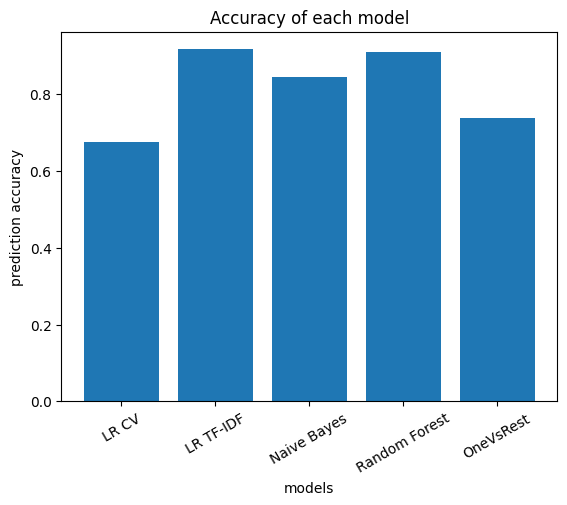

In [123]:
model = ['LR CV', 'LR TF-IDF', 'Naive Bayes', 'Random Forest', 'OneVsRest']
accuracy = [lr_CV_Accuracy2, lr_TFIDF_Accuracy2, nbAccuracy2, rfAccuracy2, ovrAccuracy]

plot_bar_x()